# Analisis exploratorio de imagenes
Este cuaderno permite explorar rapidamente los splits disponibles, revisar estadisticas basicas de anotaciones y visualizar ejemplos con cuadros delimitadores.


In [16]:
import sys
from pathlib import Path

# agrega la raíz del proyecto al path
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT))

from src.data_loader import load_annotations

In [17]:
import sys
from pathlib import Path
import json
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from IPython.display import display

PROJECT_ROOT = Path('..').resolve()
SRC_DIR = PROJECT_ROOT / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))


DATA_DIR = PROJECT_ROOT / 'data' / 'sample'
IMAGES_DIR = DATA_DIR / 'images'

ANNOTATION_FILES = {
    path.stem.replace('_annotations', ''): path
    for path in sorted(DATA_DIR.glob('*_annotations.json'))
}

if not ANNOTATION_FILES:
    raise FileNotFoundError(f'No se encontraron archivos de anotaciones en {DATA_DIR}')

DEFAULT_DATASET = 'train' if 'train' in ANNOTATION_FILES else next(iter(ANNOTATION_FILES))
DATASET_KEY = DEFAULT_DATASET

plt.style.use('ggplot')
print(f'Proyecto base: {PROJECT_ROOT}')
print(f"Splits detectados: {', '.join(ANNOTATION_FILES.keys())}")
print(f'Split seleccionado: {DATASET_KEY}')


Proyecto base: C:\Users\USER\OneDrive\Escritorio\QuantumViz_Vision-Computadora_04
Splits detectados: cis_test, cis_val, train, trans_test, trans_val
Split seleccionado: train


## Seleccion de split
Ajusta la variable DATASET_KEY en la celda anterior si quieres estudiar otro archivo de anotaciones. Cada split comparte la misma carpeta de imagenes (data/sample/images).


In [18]:
split_rows = []
for name, path in ANNOTATION_FILES.items():
    with open(path, 'r', encoding='utf-8') as fh:
        data = json.load(fh)
    split_rows.append({
        'split': name,
        'json_path': str(path),
        'num_images': len(data.get('images', [])),
        'num_annotations': len(data.get('annotations', [])),
    })

split_df = pd.DataFrame(split_rows).sort_values('split').reset_index(drop=True)
split_df


,split,json_path,num_images,num_annotations
0,cis_test,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,15827,16395
1,cis_val,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,3484,3582
2,train,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,13553,14071
3,trans_test,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,23275,24028
4,trans_val,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,1725,1865


## Carga del split y estadisticas iniciales
Se cargan las anotaciones y se verifica cuantas imagenes fueron localizadas en disco.


In [19]:
ANNOTATIONS_JSON = ANNOTATION_FILES[DATASET_KEY]
imageid_to_filepath, anns_by_image, categories = load_annotations(
    str(ANNOTATIONS_JSON), images_dir=str(IMAGES_DIR)
)

with open(ANNOTATIONS_JSON, 'r', encoding='utf-8') as fh:
    raw_data = json.load(fh)

images_meta = {
    (im.get('id') or im.get('file_name')): im
    for im in raw_data.get('images', [])
}

total_images = len(imageid_to_filepath)
total_annotations = sum(len(v) for v in anns_by_image.values())
images_with_boxes = sum(1 for boxes in anns_by_image.values() if boxes)
images_without_boxes = total_images - images_with_boxes
existing_files = sum(Path(path).exists() for path in imageid_to_filepath.values())

print(f'JSON analizado: {ANNOTATIONS_JSON.name}')
print(f'Imagenes listadas en el JSON: {len(images_meta)}')
print(f'Imagenes encontradas en disco: {existing_files}/{total_images}')
print(f'Total de anotaciones: {total_annotations}')
if total_images:
    print(f'Imagenes con objetos: {images_with_boxes} ({images_with_boxes / total_images:.1%})')
    print(f'Imagenes sin objetos: {images_without_boxes} ({images_without_boxes / total_images:.1%})')
print(f'Categorias ({len(categories)}): {sorted(categories.values())}')


JSON analizado: train_annotations.json
Imagenes listadas en el JSON: 13553
Imagenes encontradas en disco: 13553/13553
Total de anotaciones: 12617
Imagenes con objetos: 12099 (89.3%)
Imagenes sin objetos: 1454 (10.7%)
Categorias (16): ['badger', 'bird', 'bobcat', 'car', 'cat', 'coyote', 'deer', 'dog', 'empty', 'fox', 'opossum', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']


## Vista general por imagen
Tabla rapida para revisar cuantas anotaciones tiene cada imagen, sus dimensiones y si el archivo existe en disco.


In [20]:
overview_rows = []
for img_id, filepath in imageid_to_filepath.items():
    meta = images_meta.get(img_id, {})
    overview_rows.append({
        'image_id': img_id,
        'file_name': meta.get('file_name', Path(filepath).name),
        'path': filepath,
        'width': meta.get('width'),
        'height': meta.get('height'),
        'location': meta.get('location'),
        'n_objects': len(anns_by_image.get(img_id, [])),
        'exists': Path(filepath).exists(),
    })

image_overview_df = pd.DataFrame(overview_rows)
image_overview_df.head(10)


,image_id,file_name,path,width,height,location,n_objects,exists
0,5a2176e7-23d2-11e8-a6a3-ec086b02610b,5a2176e7-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,38,1,True
1,5a2177bf-23d2-11e8-a6a3-ec086b02610b,5a2177bf-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,38,1,True
2,59af966d-23d2-11e8-a6a3-ec086b02610b,59af966d-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,43,0,True
3,59a30d59-23d2-11e8-a6a3-ec086b02610b,59a30d59-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,61,1,True
4,59ffbb81-23d2-11e8-a6a3-ec086b02610b,59ffbb81-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,38,1,True
5,5a07cbea-23d2-11e8-a6a3-ec086b02610b,5a07cbea-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,61,1,True
6,598f76c9-23d2-11e8-a6a3-ec086b02610b,598f76c9-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,38,0,True
7,598de7fc-23d2-11e8-a6a3-ec086b02610b,598de7fc-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,33,0,True
8,59eab996-23d2-11e8-a6a3-ec086b02610b,59eab996-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,38,1,True
9,59973fb2-23d2-11e8-a6a3-ec086b02610b,59973fb2-23d2-11e8-a6a3-ec086b02610b.jpg,C:\Users\USER\OneDrive\Escritorio\QuantumViz_V...,2048,1494,38,1,True


## Distribucion por categoria
Conteo de objetos por clase con grafica tipo barra.


Objetos por categoria


,category_id,category_name,objects,frequency_pct
0,1,opossum,2514,19.925497
1,10,rabbit,2278,18.055005
2,9,coyote,1371,10.866292
3,16,cat,1170,9.273203
4,5,squirrel,1037,8.219070
5,3,raccoon,1030,8.163589
6,8,dog,769,6.094951
7,6,bobcat,684,5.421257
8,33,car,668,5.294444
9,11,bird,560,4.438456


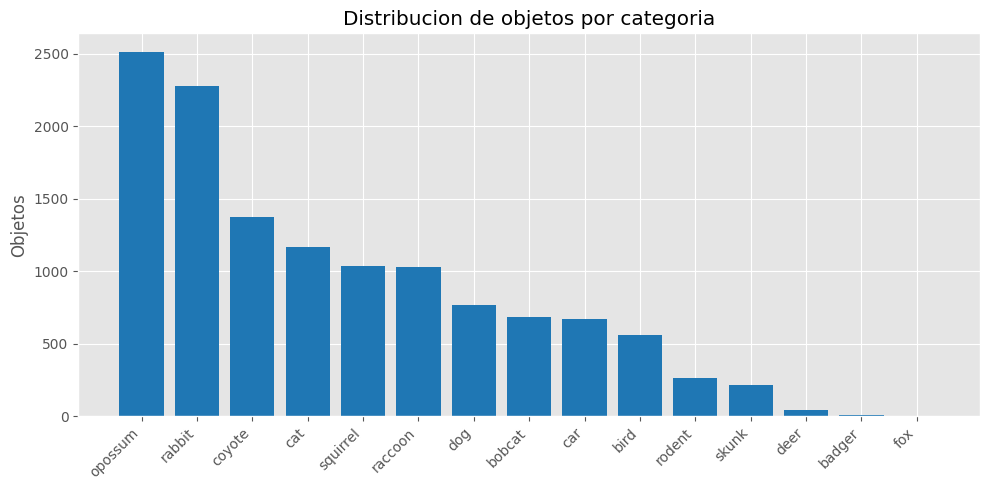

In [21]:
cat_counter = Counter()
for anns in anns_by_image.values():
    for ann in anns:
        cat_counter[ann['category_id']] += 1

cat_df = pd.DataFrame([
    {
        'category_id': cat_id,
        'category_name': categories.get(cat_id, str(cat_id)),
        'objects': count,
        'frequency_pct': (count / total_annotations * 100) if total_annotations else 0,
    }
    for cat_id, count in cat_counter.items()
]).sort_values('objects', ascending=False).reset_index(drop=True)

print('Objetos por categoria')
display(cat_df)

plt.figure(figsize=(10, 5))
plt.bar(cat_df['category_name'], cat_df['objects'], color='#1f77b4')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Objetos')
plt.title('Distribucion de objetos por categoria')
plt.tight_layout()
plt.show()


## Objetos por imagen
Histograma del numero de cuadros por imagen para detectar escenas con muchos objetos o imagenes vacias.


Bboxes -> media: 0.93, mediana: 1.00, min: 0, max: 7


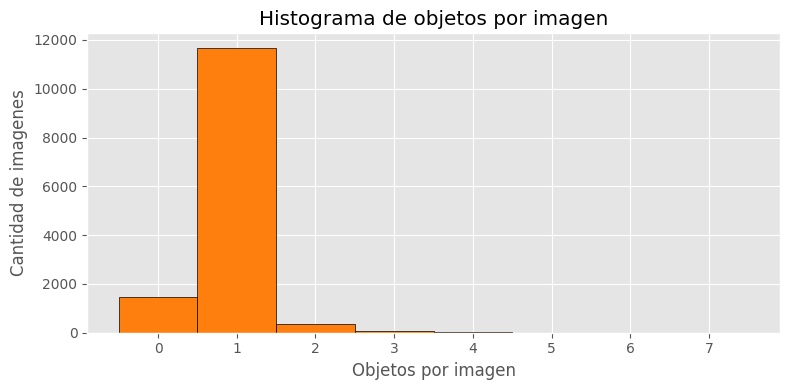

In [22]:
bbox_counts = np.array([
    len(anns_by_image.get(img_id, []))
    for img_id in imageid_to_filepath
], dtype=int)

if bbox_counts.size:
    print(
        f'Bboxes -> media: {bbox_counts.mean():.2f}, mediana: {np.median(bbox_counts):.2f}, '
        f'min: {bbox_counts.min()}, max: {bbox_counts.max()}'
    )
    plt.figure(figsize=(8, 4))
    plt.hist(bbox_counts, bins=range(int(bbox_counts.max()) + 2), color='#ff7f0e', edgecolor='black', align='left')
    plt.xlabel('Objetos por imagen')
    plt.ylabel('Cantidad de imagenes')
    plt.title('Histograma de objetos por imagen')
    plt.xticks(range(int(bbox_counts.max()) + 1))
    plt.tight_layout()
    plt.show()
else:
    print('No hay bounding boxes en este split.')


## Histogramas de intensidad
Calcula histogramas de intensidad (escala de grises) para un subconjunto de imagenes disponibles en disco.


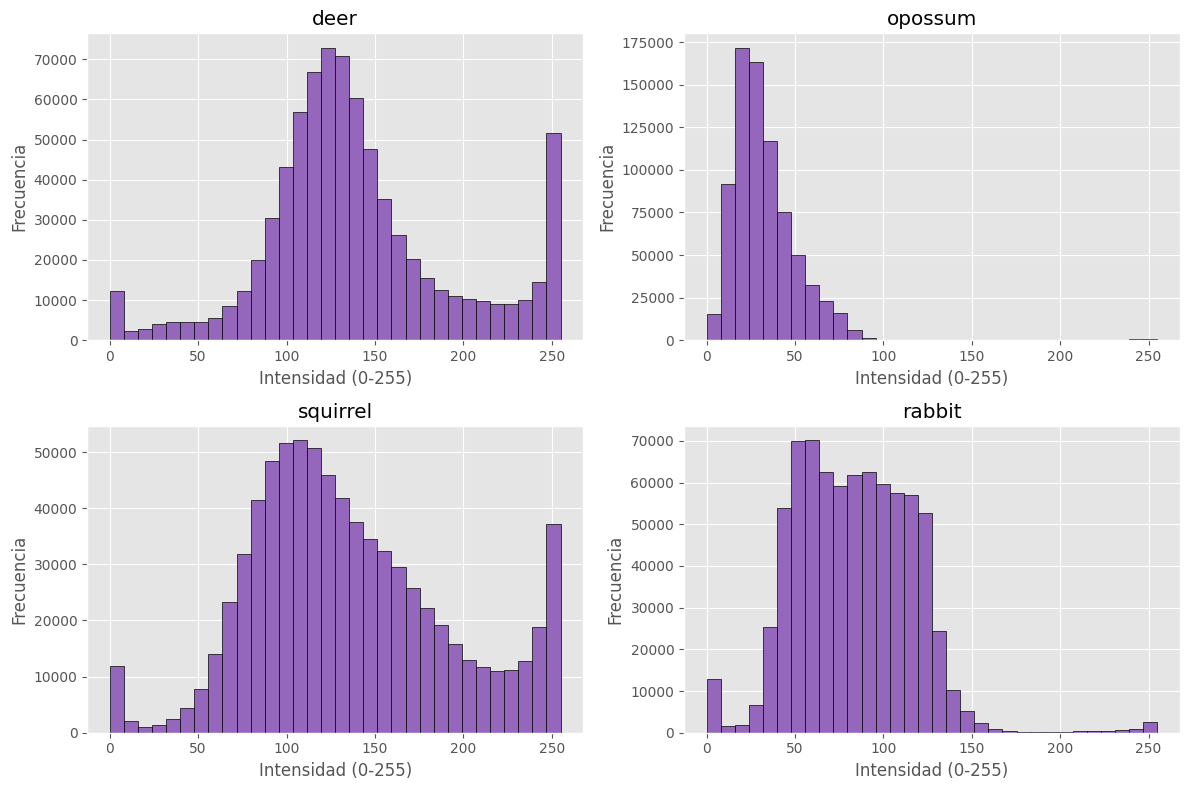

In [23]:
def _flatten_intensity(path):
    img = np.asarray(plt.imread(path))
    if img.ndim == 3 and img.shape[2] >= 3:
        img = img[..., :3]
        img = img @ np.array([0.299, 0.587, 0.114])
    elif img.ndim == 2:
        pass
    else:
        return None

    max_val = img.max() if img.size else 0
    if img.dtype != np.uint8 and max_val <= 1.0:
        img = np.clip(img, 0, 1) * 255
    return img.astype(np.float32).ravel()

annotated_ids = [img_id for img_id, anns in anns_by_image.items() if anns]
annotated_df = image_overview_df[
    image_overview_df['image_id'].isin(annotated_ids) & image_overview_df['exists']
][['image_id', 'path']]

sample_size = min(4, len(annotated_df))

if sample_size == 0:
    SAMPLED_ANNOTATED_IMAGES = []
    print('No hay imagenes anotadas disponibles para histogramas de intensidad.')
else:
    sampled_df = annotated_df.sample(n=sample_size, random_state=None)
    SAMPLED_ANNOTATED_IMAGES = sampled_df.to_dict('records')

    n_cols = 2
    n_rows = int(np.ceil(len(SAMPLED_ANNOTATED_IMAGES) / n_cols)) or 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    axes = np.atleast_1d(axes).flatten()

    for ax, record in zip(axes, SAMPLED_ANNOTATED_IMAGES):
        path = record['path']
        img_id = record['image_id']
        vals = _flatten_intensity(path)
        if vals is None or vals.size == 0:
            ax.text(0.5, 0.5, 'Imagen no soportada', ha='center', va='center')
            ax.axis('off')
            continue
        ax.hist(vals, bins=32, color='#9467bd', edgecolor='black')
        cat_labels = sorted({categories.get(ann['category_id'], 'unknown') for ann in anns_by_image.get(img_id, [])})
        title = ', '.join(cat_labels) if cat_labels else 'Sin categoria'
        ax.set_title(title)
        ax.set_xlabel('Intensidad (0-255)')
        ax.set_ylabel('Frecuencia')

    for ax in axes[len(SAMPLED_ANNOTATED_IMAGES):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## Distribucion de tamanos de bounding boxes
Analiza las dimensiones de los bounding boxes en pixeles (ancho, alto y area) para el split seleccionado.


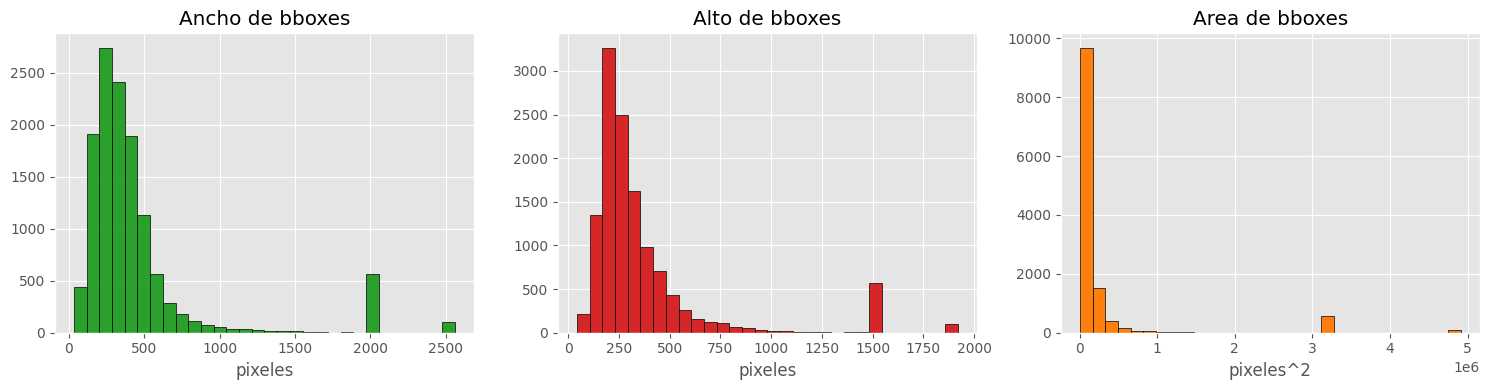

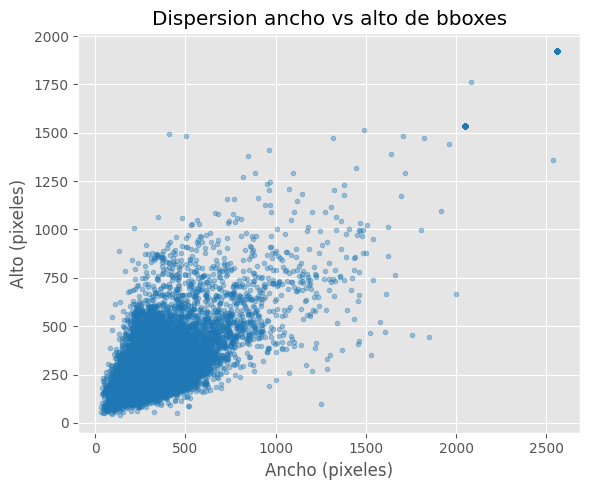

In [24]:
bbox_dims = []
for img_id, anns in anns_by_image.items():
    for ann in anns:
        x1, y1, x2, y2 = ann['bbox']
        w = max(0.0, x2 - x1)
        h = max(0.0, y2 - y1)
        bbox_dims.append({'width': w, 'height': h, 'area': w * h})

if not bbox_dims:
    print('No hay bounding boxes para analizar.')
else:
    bbox_df = pd.DataFrame(bbox_dims)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(bbox_df['width'], bins=30, color='#2ca02c', edgecolor='black')
    axes[0].set_title('Ancho de bboxes')
    axes[0].set_xlabel('pixeles')

    axes[1].hist(bbox_df['height'], bins=30, color='#d62728', edgecolor='black')
    axes[1].set_title('Alto de bboxes')
    axes[1].set_xlabel('pixeles')

    axes[2].hist(bbox_df['area'], bins=30, color='#ff7f0e', edgecolor='black')
    axes[2].set_title('Area de bboxes')
    axes[2].set_xlabel('pixeles^2')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.scatter(bbox_df['width'], bbox_df['height'], alpha=0.4, s=12, color='#1f77b4')
    plt.xlabel('Ancho (pixeles)')
    plt.ylabel('Alto (pixeles)')
    plt.title('Dispersion ancho vs alto de bboxes')
    plt.tight_layout()
    plt.show()


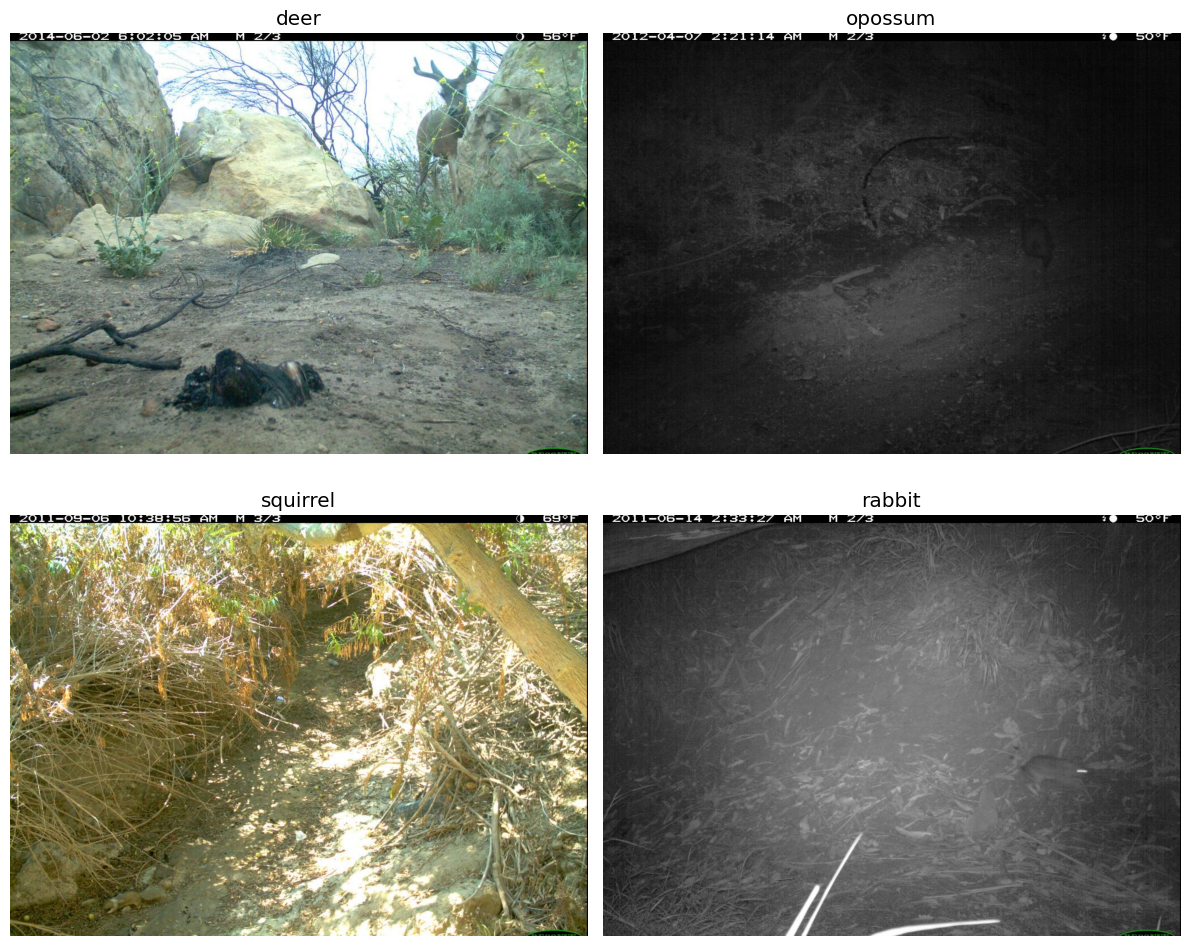

In [25]:
samples_to_show = 4

if 'SAMPLED_ANNOTATED_IMAGES' in globals() and SAMPLED_ANNOTATED_IMAGES:
    sample_records = SAMPLED_ANNOTATED_IMAGES
else:
    annotated_ids = [img_id for img_id, anns in anns_by_image.items() if anns]
    existing_ids = image_overview_df.loc[
        image_overview_df['image_id'].isin(annotated_ids) & image_overview_df['exists'],
        ['image_id', 'path']
    ]
    sample_count = min(samples_to_show, len(existing_ids))
    if sample_count:
        sampled_df = existing_ids.sample(n=sample_count, random_state=None)
        sample_records = sampled_df.to_dict('records')
    else:
        sample_records = []
    SAMPLED_ANNOTATED_IMAGES = sample_records

if not sample_records:
    print('No se encontraron imagenes anotadas en disco para mostrar.')
else:
    n_cols = 2
    n_rows = int(np.ceil(len(sample_records) / n_cols)) or 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
    axes = np.atleast_1d(axes).flatten()

    for ax, record in zip(axes, sample_records):
        img_id = record['image_id']
        img_path = Path(record['path'])
        ax.imshow(plt.imread(img_path))
        ax.axis('off')

        anns = anns_by_image.get(img_id, [])
        cat_labels = sorted({categories.get(ann['category_id'], 'unknown') for ann in anns})
        title = ', '.join(cat_labels) if cat_labels else 'Sin categoria'
        ax.set_title(title)

    for ax in axes[len(sample_records):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
